In [1]:
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd

In [2]:
# read names that have provided survey eye color data
columns = ['name', 'left', 'right', 'left_desc', 'right_desc']
# pgp eye color data from survey
surveyData = pd.read_csv("PGP-eyecolor.csv", names=columns, na_values=['nan', ''])
# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())
leftEyeColors = surveyData['left']
rightEyeColors = surveyData['right']

In [3]:
# load numpy array of names
pgpNames = np.load("names.npy")
# load numpy array of tiled data and delete the extra information
pgp = np.load("hiq-pgp.npy")
for i in range(len(pgpNames)):
    pgpNames[i] = pgpNames[i][:8]

In [4]:
def getData(name, surveyData):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            return (row['left'], row['right'])

In [5]:
# populate name dictionaries with respective eye color data
namePairIndices = []
nameLeftEyeMap = {}
nameRightEyeMap = {}
for i in range(len(pgpNames)):
    if pgpNames[i] in surveyNames:
        eyeData = getData(pgpNames[i], surveyData)
        namePairIndices.append((i, pgpNames[i]))
        nameLeftEyeMap[pgpNames[i]] = eyeData[0]
        nameRightEyeMap[pgpNames[i]] = eyeData[1]

# create lists containing the known eye color names and the unknown ones.
nameIndices = [nameIndex[0] for nameIndex in namePairIndices]
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [6]:
# convert dictionaries to lists using knownData
leftEyeNameList = []
rightEyeNameList = []

knownDataNames = [nameIndices]
for nameTuple in namePairIndices:
    leftEyeNameList.append(nameLeftEyeMap[nameTuple[1]])
    rightEyeNameList.append(nameRightEyeMap[nameTuple[1]])
    
for i in range(len(leftEyeNameList)):
    eyeColor = leftEyeNameList[i]
    if eyeColor > 17:
        leftEyeNameList[i] = 1
    else:
        leftEyeNameList[i] = 0

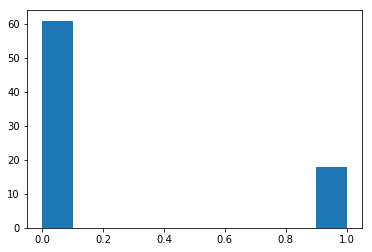

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(leftEyeNameList)
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score


crange = np.logspace(-3, 10, 20).tolist()
scores = []
stds = []
for idC, Cval in enumerate(crange):
    clf = LinearSVC(penalty='l1', class_weight='balanced', dual=False, C=Cval)
    cvscores = cross_val_score(clf, knownData, leftEyeNameList, cv=10, scoring='accuracy')
    scores.append(cvscores.mean())
    stds.append(cvscores.std() * 2)
    print "id: " + str(idC) + ", cval: " + str(Cval) + ", mean:" + str(cvscores.mean()) + ", std: " + str(cvscores.std() * 2)

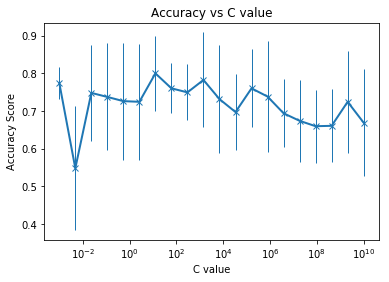

In [90]:
plt.errorbar(crange, scores, [std / 2 for std in stds], marker="x", elinewidth=1, linewidth=2)
plt.title("Accuracy vs C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xscale("log")
ax = plt.subplot(111)

plt.show()

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(knownData, leftEyeNameList, test_size=.2, random_state=2)
svc_test = LinearSVC(penalty='l1', class_weight='balanced', C=.113, dual=False)
svc_test.fit(X_train, y_train)

y_pred = svc_test.predict(X_test)
accuracy_score(y_test, y_pred)

0.6875

In [17]:
from sklearn.model_selection import GridSearchCV

crange = np.logspace(-3, 10, 20).tolist()
reg = ['l1', 'l2']
weight = [None, 'balanced']

param_grid = dict(C=crange, penalty=reg, class_weight=weight)
clf = LinearSVC(dual=False)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(knownData, leftEyeNameList)

GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.004832930238571752, 0.023357214690901226, 0.11288378916846895, 0.545559478116852, 2.636650898730358, 12.742749857031347, 61.58482110660267, 297.63514416313194, 1438.449888287663, 6951.927961775606, 33598.18286283781, 162377.67391887243, 784759.9703514623, 3792690.1907322537, 18329807.108324375, 88586679.04100832, 428133239.8719396, 2069138081.1147902, 10000000000.0], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [78]:
for score in grid.grid_scores_:
    print score

mean: 0.54430, std: 0.17498, params: {'penalty': 'l1', 'C': 0.001, 'class_weight': None}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l2', 'C': 0.001, 'class_weight': None}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l1', 'C': 0.001, 'class_weight': 'balanced'}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l2', 'C': 0.001, 'class_weight': 'balanced'}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l1', 'C': 0.004832930238571752, 'class_weight': None}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l2', 'C': 0.004832930238571752, 'class_weight': None}
mean: 0.54430, std: 0.16399, params: {'penalty': 'l1', 'C': 0.004832930238571752, 'class_weight': 'balanced'}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l2', 'C': 0.004832930238571752, 'class_weight': 'balanced'}
mean: 0.74684, std: 0.11028, params: {'penalty': 'l1', 'C': 0.023357214690901226, 'class_weight': None}
mean: 0.77215, std: 0.04227, params: {'penalty': 'l2', 'C': 0.023357214690901226, 'class_weight': No

C:\Users\kfang\Miniconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [11]:
nonzeroes = np.nonzero(clf.coef_)[1]
clf.coef_[0][nonzeroes]

array([-0.00182618, -0.04088134, -0.02454371, -0.04850267,  0.02532416,
       -0.00520539,  0.0508477 ,  0.02672121,  0.00660492, -0.03156453,
        0.05320828,  0.01364585,  0.00187606,  0.00123597,  0.0083509 ,
        0.01547678, -0.0022404 , -0.00759769,  0.00766148,  0.01274698,
       -0.00767599, -0.02183199,  0.03558189, -0.04799621,  0.01672696,
        0.01293048, -0.01080662,  0.01095777, -0.0038741 ,  0.01744841,
        0.00283146,  0.06307764,  0.02530392, -0.01929475, -0.00727601,
        0.01352809,  0.01130878, -0.01666181, -0.00338396,  0.02331226,
       -0.00506788, -0.01188222,  0.00409137, -0.00048353, -0.01253392,
       -0.00673985,  0.0038353 , -0.00896231, -0.00723344, -0.00119317,
       -0.01666841, -0.0063774 , -0.01941339])

In [12]:
print clf.coef_[0][nonzeroes].max()
print nonzeroes[clf.coef_[0][nonzeroes].argmax()]

0.0630776357992
1207239


In [48]:
from sklearn.externals import joblib
joblib.dump(clf, 'eye_classifier.pkl') 

['eye_classifier.pkl']